# Class-Conditional Synthesis with Latent Diffusion Models

## Install all the requirements and Imports


In [329]:
import argparse
import os
import time
from copy import deepcopy
from itertools import islice

import matplotlib.pyplot as plt
import numpy as np
import PIL
import imageio
from PIL import Image
from tqdm import tqdm, trange
from einops import rearrange, repeat

import torch
from torch import autocast
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import seed_everything

from omegaconf import OmegaConf

import torchvision
from torchvision import transforms, datasets
from torchvision.utils import make_grid
import torchvision.transforms.functional as tf

import kornia.augmentation as K

from ldm.util import instantiate_from_config, log_txt_as_img, default, ismap
from ldm.modules.diffusionmodules.openaimodel import EncoderUNetModel, UNetModel
from src.clipseg.models.clipseg import CLIPDensePredT


import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

device = "cuda:1" if torch.cuda.is_available() else "cpu"
!nvidia-smi

%cd /misc/student/faridk/stable-diffusion

Failed to initialize NVML: Driver/library version mismatch
/misc/student/faridk/stable-diffusion


In [330]:
device

'cpu'

In [331]:
from ldm import *

## Some Utils


In [332]:
#@title loading utils
def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device) #.cuda()
    model.eval()
    return model


def get_model(cfg_path="configs/latent-diffusion/cin256-v2.yaml", ckpt_path= "models/ldm/cin256-v2/model.ckpt"):
    config = OmegaConf.load(cfg_path)  
    model = load_model_from_config(config, ckpt_path)
    return model



def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((256, 256), resample=PIL.Image.LANCZOS)#((w, h), resample=PIL.Image.LANCZOS)
    pil_iamge = image
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image, pil_iamge


In [333]:
def generate_samples(model, sampler, classes, n_samples_per_class, ddim_steps, scale, init_image=None, t_enc=None, init_latent=None, ccdddim = False, latent_t_0 = True):

    all_samples = []
    all_probs = []
    all_videos = []
    
    with torch.no_grad():
        with model.ema_scope():
            tic = time.time()
            uc = model.get_learned_conditioning({model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)})

            for class_label in classes:
                print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
                xc = torch.tensor(n_samples_per_class*[class_label])
                c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
                if init_latent is not None:
                    y=xc.to(model.device)
                    z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*(n_samples_per_class)).to(device)) if not latent_t_0 else init_latent
                    # decode it
                    if ccdddim:
                        out = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale, unconditional_conditioning=uc, y=xc.to(model.device), latent_t_0 = latent_t_0)
                        samples = out["x_dec"]
                        prob = out["prob"]
                        vid = out["video"]
                        
                    else:
                        samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale, unconditional_conditioning=uc)

                    x_samples = model.decode_first_stage(samples)
                    x_samples_ddim = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                    cat_samples=torch.cat([init_image[:1], x_samples_ddim], dim=0)
                else:

                    samples_ddim, _ = sampler.sample(S=ddim_steps,
                                                    conditioning=c,
                                                    batch_size=n_samples_per_class,
                                                    shape=[3, 64, 64],
                                                    verbose=False,
                                                    unconditional_guidance_scale=scale,
                                                    unconditional_conditioning=uc, 
                                                    eta=ddim_eta)

                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                                min=0.0, max=1.0)
                    cat_samples=x_samples_ddim

                all_samples.append(cat_samples)
                all_probs.append(prob) if ccdddim and prob is not None else None
                all_videos.append(vid) if ccdddim and vid is not None else None


    out = {}
    out["samples"] = all_samples 
    out["probs"] = all_probs if len(all_probs) > 0 else None
    out["videos"] = all_videos if len(all_videos) > 0 else None
    return out

## Loading the models

In [334]:
# load model
# load model
model_seg = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model_seg.eval();
model_seg.load_state_dict(torch.load('src/clipseg/weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False);


In [335]:
model = get_model()

Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [336]:
from ldm.models.diffusion.ddim import DDIMSampler

sampler = DDIMSampler(model)

## Sampling from the counterfactual sampler


In [337]:
"""SAMPLING ONLY."""

import torch
import time
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F
from torch import distributions as torchd
from functools import partial

from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like, \
    extract_into_tensor
import regex as re

### Some utilities 

In [338]:
#load txt file with mapping from 'data/imagenet_clsidx_to_label.txt'
#to get the class names
i2h = dict()
with open('data/imagenet_clsidx_to_label.txt', "r") as f:
        lines = f.read().splitlines()
        assert len(lines) == 1000

        for line in lines:
            key, value = line.split(":")
            i2h[int(key)] = re.sub(r"^'|',?$", "", value.strip()) #value.strip().strip("'").strip(",").strip("\"")



In [339]:
def compute_lp_dist(diff, p):
    diff_abs_flat = diff.abs().view(diff.shape[0], -1)
    if p == 1.0:
        lp_dist = torch.sum(diff_abs_flat, dim=1)
    else:
        lp_dist = torch.sum(diff_abs_flat ** p, dim=1)
    return lp_dist


def compute_lp_gradient(diff, p, small_const=1e-12):
    if p < 1:
        grad_temp = (p * (diff.abs() + small_const) ** (

                p - 1)) * diff.sign()
    else:
        grad_temp = (p * diff.abs() ** (p - 1)) * diff.sign()
    return grad_temp


def _renormalize_gradient(grad, eps, small_const=1e-22):

    grad_norm = grad.view(grad.shape[0], -1).norm(p=2, dim=1).view(grad.shape[0], 1, 1, 1)
    grad_norm = torch.where(grad_norm < small_const, grad_norm + small_const, grad_norm)
    grad /= grad_norm
    grad *= eps.view(grad.shape[0], -1).norm(p=2, dim=1).view(grad.shape[0], 1, 1, 1)
    return grad, grad_norm

def renormalize(a, b, small_const=1e-22):
    #changes(removed detach and restored where)
    a_norm = a.view(a.shape[0], -1).norm(p=2, dim=1).view(b.shape[0], 1, 1, 1)
    a_norm_new = torch.where(a_norm < small_const, a_norm + small_const, a_norm) #torch.clamp(a_norm, min=small_const) #.detach() #torch.where(a_norm < small_const, a_norm + small_const, a_norm)
    a /= a_norm_new
    a *= b.view(a.shape[0], -1).norm(p=2, dim=1).view(a.shape[0], 1, 1, 1)
    return a, a_norm_new



class OneHotDist(torchd.one_hot_categorical.OneHotCategorical):

    def __init__(self, logits=None, probs=None):
        super().__init__(logits=logits, probs=probs)

    def mode(self):
        _mode = F.one_hot(torch.argmax(super().logits, axis=-1), super().logits.shape[-1])
        return _mode.detach() + super().logits - super().logits.detach()

    def sample(self, sample_shape=(), seed=None):
        if seed is not None:
            raise ValueError('need to check')
        sample = super().sample(sample_shape)
        probs = super().probs
        while len(probs.shape) < len(sample.shape):
            probs = probs[None]
        sample += probs - probs.detach()
        return sample


def cone_project(grad_temp_1, grad_temp_2, deg):
    """
    grad_temp_1: gradient of the loss w.r.t. the robust/classifier free
    grad_temp_2: gradient of the loss w.r.t. the non-robust
    projecting the robust/CF onto the non-robust 
    """
    angles_before = torch.acos(
        (grad_temp_1 * grad_temp_2).sum(1) / (grad_temp_1.norm(p=2, dim=1) * grad_temp_2.norm(p=2, dim=1)))
    ##print('angle before', angles_before)
    grad_temp_2 /= grad_temp_2.norm(p=2, dim=1).view(grad_temp_1.shape[0], -1)
    grad_temp_1 = grad_temp_1 - ((grad_temp_1 * grad_temp_2).sum(1) / (grad_temp_2.norm(p=2, dim=1) ** 2)).view(
        grad_temp_1.shape[0], -1) * grad_temp_2
    grad_temp_1 /= grad_temp_1.norm(p=2, dim=1).view(grad_temp_1.shape[0], -1)
    # cone_projection = grad_temp_1 + grad_temp_2 45 deg
    radians = torch.tensor([deg], device=grad_temp_1.device).deg2rad()
    ##print('angle after', radians, torch.acos((grad_temp_1*grad_temp_2).sum(1) / (grad_temp_1.norm(p=2,dim=1) * grad_temp_2.norm(p=2,dim=1))))
    cone_projection = grad_temp_1 * torch.tan(radians) + grad_temp_2

    # second classifier is a non-robust one -
    # unless we are less than 45 degrees away - don't cone project
    grad_temp = grad_temp_2.clone()
    loop_projecting = time.time()
    grad_temp[angles_before > radians] = cone_projection[angles_before > radians]

    return grad_temp

def normalize(x):
    mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    x = x - torch.tensor(mean).to(x.device)[None, :, None, None]
    x = x / torch.tensor(std).to(x.device)[None, :, None, None]
    return x

def denormalize(x):
    mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    x = x * torch.tensor(std).to(x.device)[None, :, None, None]
    x = x + torch.tensor(mean).to(x.device)[None, :, None, None]
    return x


def _map_img(x):
    #from -1 to 1 to 0 to 1 
    return 0.5 * (x + 1)

def _unmap_img(x, from_image_net_dist = False):
    #from 0 to 1 to -1 to 1

    return 2. * x -1

def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self


### Defining the new ddim 

In [340]:
def sigmoidal_threshold(img, alpha, beta):
    return 1 / (1 + np.exp(-alpha * (img - beta)))

In [341]:
class CCDDIMSampler(object):
    def __init__(self, model, classifier, model_type="latent", schedule="linear", guidance="free", lp_custom=False,
                 deg_cone_projection=10, denoise_dist_input=True, classifier_lambda=1, dist_lambda=0.15,
                 enforce_same_norms=True, seg_model = None, masked_guidance = False, backprop_diffusion = True, mask_alpha = 3., **kwargs):

        super().__init__()
        self.model_type = model_type
        self.lp_custom = lp_custom
        self.images = []
        self.probs = []
        self.classifier_lambda = classifier_lambda
        self.model = model
        self.ddpm_num_timesteps = model.num_timesteps
        self.schedule = schedule
        self.classifier = classifier
        self.guidance = guidance
        self.backprop_diffusion = backprop_diffusion
        # self.projected_counterfactuals = projected_counterfactuals
        self.deg_cone_projection = deg_cone_projection
        self.denoise_dist_input = denoise_dist_input
        self.dist_lambda = dist_lambda
        self.enforce_same_norms = enforce_same_norms
        self.seg_model = seg_model
        self.masked_guidance = masked_guidance
        self.mask_alpha = mask_alpha

        self.init_images = None
        self.init_labels = None
        self.mask = None

    def get_classifier_dist(self, x, t=None):
        """
        Create a distribution over the classifier output space
        Args:
            x: input image for which to create the distribution over the classifier output space range [-1, 1]

        Returns:
            dist: torch distribution over the classifier output space

        """
        x = tf.center_crop(x, 224)
        x = normalize(_map_img(x))
        logit = self.classifier(x)  # (TODO) add option for t here
        dist = torchd.independent.Independent(OneHotDist(logit), 1)
        return dist


    def get_mask(self):
        """
        this function returns a negative mask given by a segmentation model for the region of interest
        values are higher outside the region of interest
        """

        if self.mask is not None:
            return self.mask

        prompts = []
        for l in self.init_labels:
            prompts.append(re.sub(r'\b(\w)', lambda m: m.group(1).upper(), i2h[l]))
        
        with torch.no_grad():
            print("input range", self.init_images.min(), self.init_images.max())
            img_to_seg=F.interpolate(normalize(self.init_images), size=(352, 352), mode='bilinear', align_corners=False).to(device)
            print("input range after", img_to_seg.min(), img_to_seg.max())
            print(f"prompt {prompts}")
            preds = self.seg_model(img_to_seg, prompts)[0]
            print("preds range", preds.min(), preds.max())
            preds = F.interpolate(preds, size=self.init_images.shape[-2:], mode='bilinear', align_corners=False)
            preds = torch.sigmoid(preds) #torch.softmax(preds.view(preds.shape[0], -1), dim=1).view(*preds.shape)
            print("preds range after first seg ", preds.min(), preds.max())
            #scale to [0,1]
            preds = (preds - preds.min()) / (preds.max() - preds.min())
            preds = torch.sigmoid(self.mask_alpha*2*(preds-0.5))
            print("preds afet second seg range", preds.min(), preds.max())
            
        self.mask = preds.to(device)
        return self.mask
        
    def get_output(self, x, t, c, index, unconditional_conditioning, use_original_steps=True, quantize_denoised=True, return_decoded=False):
        b = x.shape[0]
        x_in = torch.cat([x] * 2)
        t_in = torch.cat([t] * 2)
        c_in = torch.cat([unconditional_conditioning, c])
        with torch.enable_grad() if self.backprop_diffusion else torch.no_grad():
            e_t_uncond, e_t = self.model.apply_model(x_in, t_in, c_in).chunk(2)
            
        if return_decoded:
            # getting the original denoised image
            alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
            sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
            a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
            sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index], device=device)
            # current prediction for x_0
            # get the original image with range [0, 1] if it is in latent space
            pred_latent_x0 = (x - sqrt_one_minus_at * e_t_uncond) / a_t.sqrt() # e_t - >  e_t_uncond
            if quantize_denoised:
                pred_latent_x0, _, *_ = self.model.first_stage_model.quantize(pred_latent_x0)

            
            pred_x0 = self.model.differentiable_decode_first_stage(
                pred_latent_x0)  # if self.model_type == "latent" else pred_latent_x0
            #pred_x0 = torch.clamp((pred_x0 + 1.0) / 2.0, min=0.0, max=1.0)
            return e_t_uncond, e_t, pred_x0
        
        else:
            return e_t_uncond, e_t

    def conditional_score(self, x, t, c, index, use_original_steps, quantize_denoised, unconditional_guidance_scale=1.,
                          unconditional_conditioning=None, y=None):
        """

        Args:
            x: input image
            t: time step
            c: conditioning
            index: index for the schedule
            use_original_steps: whether to use the original steps
            quantize_denoised: whether to quantize the denoised image
            unconditional_guidance_scale: scale for the unconditional guidance
            unconditional_conditioning: unconditional conditioning
            y: target class


        Returns:
            e_t: score after conditioning

        """
        b, *_, device = *x.shape, x.device
        x = x.detach()#.requires_grad_()
        #x.requires_grad = True
        prob_best_class = None
        mask_guidance  = None

        ## check if gradient tracking is on for x
        
        
        if unconditional_conditioning is None or unconditional_guidance_scale == 1.:
            e_t = self.model.apply_model(x, t, c)
            return e_t

        
        #print("check gradient tracking onf e ", e_t.requires_grad)
        if self.guidance == "free":
            e_t_uncond, e_t, pred_x0 = self.get_output(x, t, c, index, unconditional_conditioning, use_original_steps, quantize_denoised, return_decoded=True)
            e_t = e_t_uncond + unconditional_guidance_scale * (e_t - e_t_uncond)
            return e_t

        #print("check gradient tracking onf e ", e_t.requires_grad)
        score_out = torch.zeros_like(x)
        
        with torch.enable_grad():
            assert x.requires_grad == False, "x requires grad"
            
            if self.classifier_lambda != 0:
                x_grad = x.detach().requires_grad_()
                e_t_uncond, e_t, pred_x0 = self.get_output(x_grad, t, c, index, unconditional_conditioning, use_original_steps, quantize_denoised=quantize_denoised, return_decoded=True)
                classifier_dist = self.get_classifier_dist(pred_x0)
                y_one_hot = F.one_hot(y, classifier_dist.event_shape[-1]).to(device)
                log_probs = classifier_dist.log_prob(y_one_hot)
                prob_best_class = torch.exp(log_probs)
                #print("prob_best_class", prob_best_class, log_probs)

                grad_classifier = torch.autograd.grad(log_probs, x_grad)[
                    0]
        with torch.enable_grad():  
            if self.lp_custom:
                assert x.requires_grad == False, "x requires grad"
                x_grad = x.detach().requires_grad_()
                e_t_uncond, e_t, pred_x0 = self.get_output(x_grad, t, c, index, unconditional_conditioning, use_original_steps, quantize_denoised=quantize_denoised, return_decoded=True)
                #print("computing the lp gradient")
                assert pred_x0.requires_grad == True, "pred_x0 does not require grad"
                pred_x0_0to1 = torch.clamp(_map_img(pred_x0), min=0.0, max=1.0)
                
                diff =  pred_x0_0to1 - self.init_images.to(device)
                #print("diff is:", diff.mean())
                lp_dist = compute_lp_dist(diff, self.lp_custom)
                lp_grad = torch.autograd.grad(lp_dist.mean(), x_grad)[0]

        #assert e_t_uncond.requires_grad == True and e_t.requires_grad == True, "e_t_uncond and e_t should require gradients"
        

        if self.guidance == "projected":
            implicit_classifier_score = (e_t - e_t_uncond)#.detach()
            # check gradient tracking on implicit_classifier_score 
            assert implicit_classifier_score.requires_grad == False, "implicit_classifier_score requires grad"

        if self.lp_custom or self.classifier_lambda != 0:
            alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
            a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
            
        if self.classifier_lambda != 0:

            classifier_score = -1  * grad_classifier * (1 - a_t).sqrt()
            assert classifier_score.requires_grad == False, "classifier_score requires grad"
            # project the gradient of the classifier on the implicit classifier
            classifier_score = cone_project(implicit_classifier_score.view(x.shape[0], -1),
                                            classifier_score.view(x.shape[0], -1),
                                            self.deg_cone_projection).view_as(classifier_score) \
                if self.guidance == "projected" else classifier_score

            if self.enforce_same_norms:
                score_, norm_ = _renormalize_gradient(classifier_score, implicit_classifier_score)  # e_t_uncond (AWAREE!!) 
                classifier_score = self.classifier_lambda * score_
                
            else:
                classifier_score *= self.classifier_lambda

            #print("classifier score is", classifier_score.mean(), "classifier norm is", classifier_score.view(classifier_score.shape[0], -1).norm(p=2, dim=1).mean())
            score_out += classifier_score

        # distance gradients
        if self.lp_custom:
            
            lp_score = -1 * lp_grad * (1 - a_t).sqrt()
            if self.enforce_same_norms:
                # dont renormalize the implicit classifier score because it is already renormalized in the cone projection
                score_, norm_ = _renormalize_gradient(lp_score, implicit_classifier_score) # e_t_uncond if self.classifier_lambda == 0 else implicit_classifier_score) #.detach()) #, implicit_classifier_score) (AWAREE!!)
                lp_score = self.dist_lambda * score_

            else:
                
                lp_score *= self.dist_lambda
                
            score_out -= lp_score

        e_t = e_t_uncond + unconditional_guidance_scale * score_out  # (1 - a_t).sqrt() * grad_out

        #adding images to create a gif
        pred_x0_copy = pred_x0.clone().detach()
        img = torch.clamp(_map_img(pred_x0_copy), min=0.0, max=1.0)
        img = torch.permute(img, (1, 2, 0, 3)).reshape((img.shape[1], img.shape[2], -1))

        self.images.append(img)

        if prob_best_class is not None:
            self.probs.append(prob_best_class)
        
        return e_t

    def register_buffer(self, name, attr):
        if type(attr) == torch.Tensor:
            pass
            # TODO: this is a hack to make it work on CPU
            #if attr.device != torch.device("cuda"):
            #    attr = attr.to(torch.device("cuda"))
        setattr(self, name, attr)

    def make_schedule(self, ddim_num_steps, ddim_discretize="uniform", ddim_eta=0., verbose=True):
        self.ddim_timesteps = make_ddim_timesteps(ddim_discr_method=ddim_discretize, num_ddim_timesteps=ddim_num_steps,
                                                  num_ddpm_timesteps=self.ddpm_num_timesteps, verbose=verbose)
        alphas_cumprod = self.model.alphas_cumprod
        assert alphas_cumprod.shape[0] == self.ddpm_num_timesteps, 'alphas have to be defined for each timestep'
        to_torch = lambda x: x.clone().detach().to(torch.float32).to(self.model.device)

        self.register_buffer('betas', to_torch(self.model.betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(self.model.alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod.cpu())))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod.cpu())))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu() - 1)))

        # ddim sampling parameters
        ddim_sigmas, ddim_alphas, ddim_alphas_prev = make_ddim_sampling_parameters(alphacums=alphas_cumprod.cpu(),
                                                                                   ddim_timesteps=self.ddim_timesteps,
                                                                                   eta=ddim_eta, verbose=verbose)
        self.register_buffer('ddim_sigmas', ddim_sigmas)
        self.register_buffer('ddim_alphas', ddim_alphas)
        self.register_buffer('ddim_alphas_prev', ddim_alphas_prev)
        self.register_buffer('ddim_sqrt_one_minus_alphas', np.sqrt(1. - ddim_alphas))
        sigmas_for_original_sampling_steps = ddim_eta * torch.sqrt(
            (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * (
                    1 - self.alphas_cumprod / self.alphas_cumprod_prev))
        self.register_buffer('ddim_sigmas_for_original_num_steps', sigmas_for_original_sampling_steps)

    @torch.no_grad()
    def sample(self,
               S,
               batch_size,
               shape,
               conditioning=None,
               callback=None,
               normals_sequence=None,
               img_callback=None,
               quantize_x0=False,
               eta=0.,
               mask=None,
               x0=None,
               temperature=1.,
               noise_dropout=0.,
               score_corrector=None,
               corrector_kwargs=None,
               verbose=True,
               x_T=None,
               log_every_t=100,
               unconditional_guidance_scale=1.,
               unconditional_conditioning=None,
               # this has to come in the same format as the conditioning, # e.g. as encoded tokens, ...
               **kwargs
               ):
        if conditioning is not None:
            if isinstance(conditioning, dict):
                cbs = conditioning[list(conditioning.keys())[0]].shape[0]
                if cbs != batch_size:
                    print(f"Warning: Got {cbs} conditionings but batch-size is {batch_size}")
            else:
                if conditioning.shape[0] != batch_size:
                    print(f"Warning: Got {conditioning.shape[0]} conditionings but batch-size is {batch_size}")

        self.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)
        # sampling
        C, H, W = shape
        size = (batch_size, C, H, W)
        print(f'Data shape for DDIM sampling is {size}, eta {eta}')

        samples, intermediates = self.ddim_sampling(conditioning, size,
                                                    callback=callback,
                                                    img_callback=img_callback,
                                                    quantize_denoised=quantize_x0,
                                                    mask=mask, x0=x0,
                                                    ddim_use_original_steps=False,
                                                    noise_dropout=noise_dropout,
                                                    temperature=temperature,
                                                    score_corrector=score_corrector,
                                                    corrector_kwargs=corrector_kwargs,
                                                    x_T=x_T,
                                                    log_every_t=log_every_t,
                                                    unconditional_guidance_scale=unconditional_guidance_scale,
                                                    unconditional_conditioning=unconditional_conditioning,
                                                    )
        return samples, intermediates

    @torch.no_grad()
    def ddim_sampling(self, cond, shape,
                      x_T=None, ddim_use_original_steps=False,
                      callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, log_every_t=100,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None, ):

        device = self.model.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        if timesteps is None:
            timesteps = self.ddpm_num_timesteps if ddim_use_original_steps else self.ddim_timesteps
        elif timesteps is not None and not ddim_use_original_steps:
            subset_end = int(min(timesteps / self.ddim_timesteps.shape[0], 1) * self.ddim_timesteps.shape[0]) - 1
            timesteps = self.ddim_timesteps[:subset_end]

        intermediates = {'x_inter': [img], 'pred_x0': [img]}
        time_range = reversed(range(0, timesteps)) if ddim_use_original_steps else np.flip(timesteps)
        total_steps = timesteps if ddim_use_original_steps else timesteps.shape[0]
        print(f"Running DDIM Sampling with {total_steps} timesteps")

        iterator = tqdm(time_range, desc='DDIM Sampler', total=total_steps)

        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            ts = torch.full((b,), step, device=device, dtype=torch.long)

            if mask is not None:
                assert x0 is not None
                img_orig = self.model.q_sample(x0, ts)  # TODO: deterministic forward pass?
                img = img_orig * mask + (1. - mask) * img

            outs = self.p_sample_ddim(img, cond, ts, index=index, use_original_steps=ddim_use_original_steps,
                                      quantize_denoised=quantize_denoised, temperature=temperature,
                                      noise_dropout=noise_dropout, score_corrector=score_corrector,
                                      corrector_kwargs=corrector_kwargs,
                                      unconditional_guidance_scale=unconditional_guidance_scale,
                                      unconditional_conditioning=unconditional_conditioning)
            img, pred_x0 = outs
            if callback: callback(i)
            if img_callback: img_callback(pred_x0, i)

            if index % log_every_t == 0 or index == total_steps - 1:
                intermediates['x_inter'].append(img)
                intermediates['pred_x0'].append(pred_x0)

        return img, intermediates

    @torch.no_grad()
    def p_sample_ddim(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None,
                      unconditional_guidance_scale=1., unconditional_conditioning=None, y=None):
        b, *_, device = *x.shape, x.device

        e_t = self.conditional_score(x=x, c=c, t=t, index=index, use_original_steps=use_original_steps,
                                     quantize_denoised=quantize_denoised,
                                     unconditional_guidance_scale=unconditional_guidance_scale,
                                     unconditional_conditioning=unconditional_conditioning, y=y)

        if score_corrector is not None:
            assert self.model.parameterization == "eps"
            e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

        alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
        alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
        sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
        sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas
        # select parameters corresponding to the currently considered timestep
        a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index], device=device)

        # current prediction for x_0
        pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
        if quantize_denoised:
            pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
        # direction pointing to x_t
        dir_xt = (1. - a_prev - sigma_t ** 2).sqrt() * e_t
        noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
        return x_prev, pred_x0

    @torch.no_grad()
    def stochastic_encode(self, x0, t, use_original_steps=False, noise=None):
        # fast, but does not allow for exact reconstruction
        # t serves as an index to gather the correct alphas
        if use_original_steps:
            sqrt_alphas_cumprod = self.sqrt_alphas_cumprod
            sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod
        else:
            sqrt_alphas_cumprod = torch.sqrt(self.ddim_alphas).to(x0.device)
            sqrt_one_minus_alphas_cumprod = self.ddim_sqrt_one_minus_alphas.to(x0.device)

        if noise is None:
            noise = torch.randn_like(x0)
        return (extract_into_tensor(sqrt_alphas_cumprod, t, x0.shape) * x0 +
                extract_into_tensor(sqrt_one_minus_alphas_cumprod, t, x0.shape) * noise)

    @torch.no_grad()
    def decode(self, x_latent, cond, t_start, y=None, unconditional_guidance_scale=1.0, unconditional_conditioning=None,
               use_original_steps=False, latent_t_0=False):

        timesteps = np.arange(self.ddpm_num_timesteps) if use_original_steps else self.ddim_timesteps
        timesteps = timesteps[:t_start]

        time_range = np.flip(timesteps)
        total_steps = timesteps.shape[0]
        print(f"Running DDIM Sampling with {total_steps} timesteps")

        if self.masked_guidance:
            print("### Getting the mask ###")
            mask = self.get_mask()
            mask = F.interpolate(mask, size=x_latent.shape[-2:], mode='bilinear', align_corners=True)
            #normalize the mask
            mask = (mask - mask.min()) / (mask.max() - mask.min())
            mask[mask < 0.5] = 0.
            mask[mask >= 0.5] = 1.
            # plot the mask
            
            print("### Mask shape: ", mask.shape, mask.min(), mask.max(), mask.mean(), mask.std(), "###")
            mask_plt = mask[0].permute(1, 2, 0).cpu().numpy()
            plt.imshow(mask_plt)
            plt.show()

        iterator = tqdm(time_range, desc='Decoding image', total=total_steps)

        # if latent_t_0:
        #     x_orig = x_latent
        #     x_dec = self.stochastic_encode(x_latent.clone(),
        #                                    torch.tensor([t_start] * (x_latent.shape[0])).to(x_latent.device))
        # else:
        #     
        x_dec = x_latent

        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            ts = torch.full((x_latent.shape[0],), step, device=x_latent.device, dtype=torch.long)

            if self.masked_guidance and latent_t_0:
                print("blending with original image")
                img_orig = self.model.q_sample(x_latent.clone(), ts)
                img = img_orig * (1. - mask) + (mask) * x_dec

            
            x_dec, _ = self.p_sample_ddim(x_dec, cond, ts, index=index, use_original_steps=use_original_steps,
                                          unconditional_guidance_scale=unconditional_guidance_scale,
                                          unconditional_conditioning=unconditional_conditioning, y=y)
            

        out = {}
        out['x_dec'] = x_dec
        out["mask"] = mask if self.masked_guidance else None
        out['video'] = torch.stack(self.images, dim=0) if len(self.images) != 0 else None
        # print(f"Video shape: {out['video'].shape}")
        out['prob'] = self.probs[-1].item() if len(self.probs) != 0 else None
        self.images = []
        self.probs = []
        self.mask = None
        return out

### Getting a classifier from torch vision

In [342]:
device

'cpu'

In [343]:
classifier_name = "efficientnet_b0"
classifier_model=getattr(torchvision.models, classifier_name)(pretrained=True).to(device)
classifier_model = classifier_model.eval()
classifier_model.train = disabled_train


### Getting a model, latent and wrapping in sampler

In [344]:
model = get_model()

Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [345]:
image_path = 'data/imagenette2/train/n03445777/ILSVRC2012_val_00002314.JPEG'

strength = 0.3 #48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
n_samples_per_class = batch_size = 3
ddim_steps = 250
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


In [346]:
t_enc = int(strength * ddim_steps)

In [347]:
t_enc

75

In [348]:

sampler = CCDDIMSampler(model, classifier_model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)



### Creating the Counterfactual sampler


## Now generating for the images of interest 

In [349]:
torch.autograd.set_detect_anomaly(True)

In [350]:
import wandb
os.environ["WANDB_API_KEY"] = 'cff06ca1fa10f98d7fde3bf619ee5ec8550aba11'
run = wandb.init(entity="kifarid", project="cdiff")



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kifarid. Use `wandb login --relogin` to force relogin


In [78]:
my_table = wandb.Table(columns = ["image", "source", "target", *[f"gen_image_{i}" for i in range(n_samples_per_class)], "class_prediction", "closness_1", "closness_2", "video"])



In [351]:
import yaml
strength = 0.3#0.28#48#46#"strength for noising/unnoising. 1.0 corresponds to full destruction of information in init image"
ddim_steps = 250
sampler = CCDDIMSampler(model, classifier_model)
sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
t_enc = int(strength * ddim_steps)
precision = "autocast" #"full"
precision_scope = autocast if precision == "autocast" else nullcontext
n_samples_per_class = 3

sampler.enforce_same_norms = True
sampler.guidance = "projected"
sampler.classifier_lambda = 3 #.2 #1.8 #2 final #1.5 #2.5 # 5.5 best 
sampler.dist_lambda = 1 # 0.15
sampler.masked_guidance = True
sampler.seg_model = model_seg
sampler.backprop_diffusion = False
sampler.mask = None


sampler.lp_custom = 1 



data_path = '/misc/scratchSSD2/datasets/ILSVRC2012/val'
out_size = 256
transform_list = [
    transforms.Resize((out_size,out_size)),
    transforms.ToTensor()
]
transform = transforms.Compose(transform_list)
dataset = datasets.ImageFolder(data_path,  transform=transform)
with open('data/synset_closest_idx.yaml', 'r') as file:
    synset_closest_idx = yaml.safe_load(file)


converting 14736 from : brown bear, bruin, Ursus arctos to: ['American black bear, black bear, Ursus americanus, Euarctos americanus', 'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus']


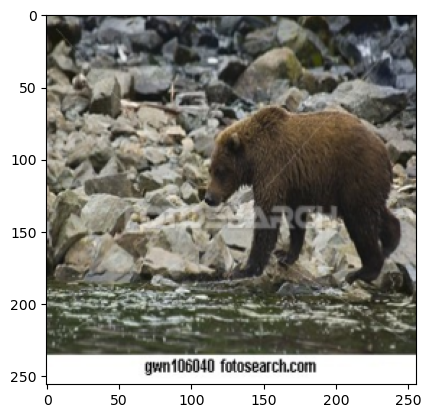

rendering 3 examples of class '295' in 250 steps and using s=3.00.
Running DDIM Sampling with 75 timesteps
### Getting the mask ###
input range tensor(0.) tensor(1.)
input range after tensor(-2.0071) tensor(2.6400)
prompt ['Brown Bear, Bruin, Ursus Arctos', 'Brown Bear, Bruin, Ursus Arctos', 'Brown Bear, Bruin, Ursus Arctos']
preds range tensor(-7.6746) tensor(2.9631)
preds range after first seg  tensor(0.0005) tensor(0.9507)
preds afet second seg range tensor(0.0474) tensor(0.9526)
### Mask shape:  torch.Size([3, 1, 64, 64]) tensor(0.) tensor(1.) tensor(0.1682) tensor(0.3741) ###


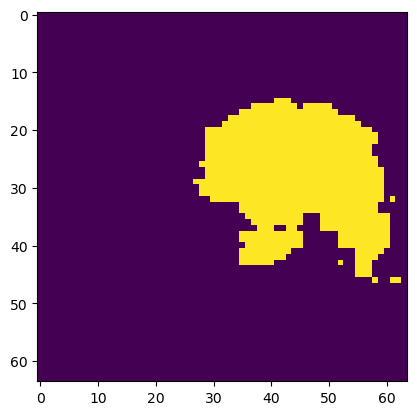

Decoding image:   0%|          | 0/75 [00:00<?, ?it/s]

blending with original image


NameError: name 'b' is not defined

In [352]:
for i, sample in enumerate(dataset, 14736):
    image, label = dataset[i]
    tgt_classes = synset_closest_idx[label]
    print(f"converting {i} from : {i2h[label]} to: {[i2h[tgt_class] for tgt_class in tgt_classes]}")
    init_image = image.repeat(n_samples_per_class, 1, 1, 1).to(device)
    plt.imshow(init_image[0].permute(1, 2, 0).detach().cpu().numpy())
    plt.show()
    sampler.init_images = init_image
    
    sampler.init_labels = n_samples_per_class*[label]
    mapped_image = _unmap_img(init_image)
    init_latent = model.get_first_stage_encoding(model.encode_first_stage(_unmap_img(init_image))) # move to latent space
   
    out =generate_samples(model, sampler, tgt_classes, n_samples_per_class, ddim_steps, scale, init_latent=init_latent, t_enc=t_enc, init_image=init_image, ccdddim=True)

    all_samples = out["samples"]
    all_videos = out["videos"]
    all_probs = out["probs"]

    # Loop through your data and update the table incrementally
    for i in range(len(all_probs)):
        # Generate data for the current row
        src_image = all_samples[i][0]
        src_image = wandb.Image(src_image)
        #my_table.update_column("image", [wandb.Image(src_image)], row_idx=i)
        gen_images = []
        for j in range(n_samples_per_class):
            gen_image = all_samples[i][j+1]
            gen_images.append(wandb.Image(gen_image))
            #my_table.update_column(f"gen_image_{j}", [wandb.Image(gen_image)], row_idx=i)

        class_prediction = all_probs[i]
        source = i2h[label]
        target = i2h[tgt_classes[i]]

        diff = 255.*(init_image-all_samples[i][1:]).permute(0, 2, 3, 1).detach().cpu().numpy()
        closeness_2 = int(np.linalg.norm(diff.astype(np.uint8), axis=-1).mean())
        closeness_1 = int(np.abs(diff).sum(axis=-1).mean())

        video = wandb.Video((255.*all_videos[i]).to(torch.uint8), fps=1, format="gif")
        my_table.add_data(src_image, source, target, *gen_images, class_prediction, closeness_1, closeness_2, video)

        run.log({"dvce_video": my_table})

run.log({"dvce_video_complete": my_table})